In [1]:
import pysm3
import pysm3.units as u
from pysm3 import models
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import toml
import copy
import seaborn as sns
sns.set_theme(style="whitegrid")


## Dust Model

In [2]:
# yaml file - /bigdata/aankit/cmb-ml/cmbml/cfg/model/sim/sim_flex_fgs.yaml

nside = 2048
freq = 545 
sky = pysm3.Sky(nside=nside, preset_strings=["d9"]) 
map_dust_default = sky.get_emission(freq * u.GHz)  
nilc_mask_fn = "/bigdata/cmb_project/data/Assets/Planck/COM_CMB_IQU-nilc_2048_R3.00_full.fits"
mask = hp.read_map(nilc_mask_fn, field=3) #field 3 for temp, 4 for polarization

/bigdata/aankit/miniconda/envs/cmb-ml-py-312/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
def get_masked_map(sky_map, mask):
    sky_map_masked = hp.ma(sky_map[0])
    sky_map_masked.mask = np.logical_not(mask)
    return sky_map_masked

In [4]:
map_dust_default_mask = get_masked_map(map_dust_default, mask)
map_dust_default_mask.shape

(50331648,)

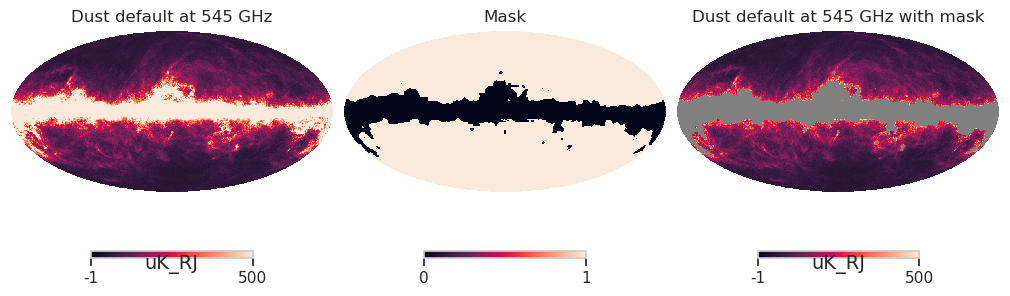

In [5]:
min = -1
max = 500

plt.figure(figsize=(10, 12))
hp.mollview(map_dust_default[0], 
            title=f"Dust default at {freq} GHz", 
            unit=map_dust_default.unit, 
            min = min, 
            max = max,
            sub=(1, 3, 1))

hp.mollview(mask, title="Mask", sub=(1, 3, 2))
hp.mollview(map_dust_default_mask, 
            title=f"Dust default at {freq} GHz with mask", 
            unit=map_dust_default.unit, 
            min = min, 
            max = max,
            sub=(1, 3, 3))

plt.show()

## Modified Dust

In [6]:
base_dust = models.ModifiedBlackBody(
    nside=nside,
    map_I=f"dust_gnilc/gnilc_dust_template_nside2048_2023.02.10.fits",
    map_mbb_index=1.48, #default
    map_mbb_temperature=19.6, #default
    unit_mbb_temperature="K",
    freq_ref_I="353 GHz",
    freq_ref_P="353 GHz"
)

In [7]:
dust_index_low = copy.deepcopy(base_dust)
dust_index_high = copy.deepcopy(base_dust)
dust_temp_low = copy.deepcopy(base_dust)
dust_temp_high = copy.deepcopy(base_dust)
print(f"dust index low before modifying: {dust_index_low.mbb_index}")
dust_index_low.mbb_index = 1.332 * u.dimensionless_unscaled
dust_index_high.mbb_index = 1.628 * u.dimensionless_unscaled
dust_temp_low.mbb_temperature = 17.64 * u.K
dust_temp_high.mbb_temperature = 21.56 * u.K
print(f"dust index after before modifying: {dust_index_low.mbb_index}")



dust index low before modifying: 1.48
dust index after before modifying: 1.332


In [8]:
sky1 = pysm3.Sky(nside=nside, component_objects=[dust_index_low])
sky2 = pysm3.Sky(nside=nside, component_objects=[dust_index_high])
sky3 = pysm3.Sky(nside=nside, component_objects=[dust_temp_low])
sky4 = pysm3.Sky(nside=nside, component_objects=[dust_temp_high])

sky_map_param1_unmasked = sky1.get_emission(freq * u.GHz)  
sky_map_param1 = get_masked_map(sky_map_param1_unmasked, mask)
sky_map_param2_unmasked = sky2.get_emission(freq * u.GHz)
sky_map_param2 = get_masked_map(sky_map_param2_unmasked, mask)
sky_map_param3_unmasked = sky3.get_emission(freq * u.GHz) 
sky_map_param3 = get_masked_map(sky_map_param3_unmasked, mask)
sky_map_param4_unmasked = sky4.get_emission(freq * u.GHz) 
sky_map_param4 = get_masked_map(sky_map_param4_unmasked, mask) 


In [9]:
print(sky_map_param1_unmasked.shape, sky_map_param1.shape)

(3, 50331648) (50331648,)


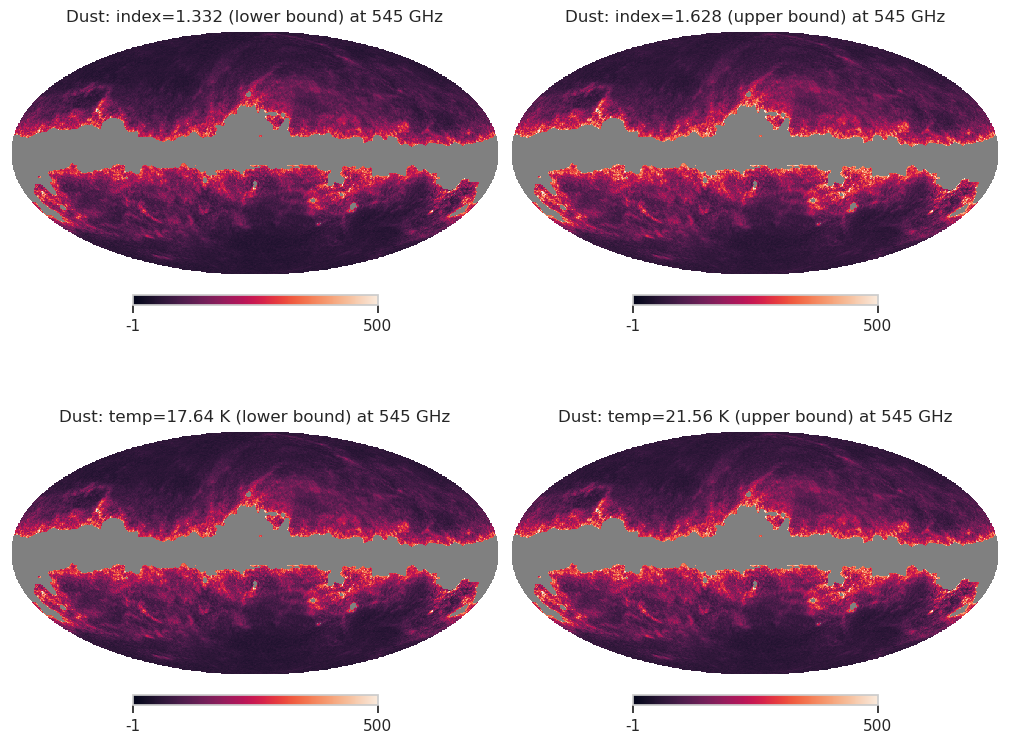

In [10]:
min = -1
max = 500
plt.figure(figsize=(10, 8))

hp.mollview(sky_map_param1, sub=(2,2,1), title=f"Dust: index={dust_index_low.mbb_index} (lower bound) at {freq} GHz", min = min, max = max)
hp.mollview(sky_map_param2, sub=(2,2,2), title=f"Dust: index={dust_index_high.mbb_index} (upper bound) at {freq} GHz", min = min, max = max)
hp.mollview(sky_map_param3, sub=(2,2,3), title=f"Dust: temp={dust_temp_low.mbb_temperature} (lower bound) at {freq} GHz", min = min, max = max)
hp.mollview(sky_map_param4, sub=(2,2,4), title=f"Dust: temp={dust_temp_high.mbb_temperature} (upper bound) at {freq} GHz", min = min, max = max)


plt.show()

## Difference of maps

In [11]:
print(type(map_dust_default), type(sky_map_param1),  type(map_dust_default_mask))

<class 'astropy.units.quantity.Quantity'> <class 'numpy.ma.core.MaskedArray'> <class 'numpy.ma.core.MaskedArray'>


In [12]:
percentile=80
difference1 = map_dust_default_mask - sky_map_param1
v1 = np.percentile(np.abs(difference1), percentile)
difference2 = map_dust_default_mask - sky_map_param2
v2 = np.percentile(np.abs(difference2), percentile)
difference3 = map_dust_default_mask - sky_map_param3
v3 = np.percentile(np.abs(difference3), percentile)
difference4 = map_dust_default_mask - sky_map_param4
v4 = np.percentile(np.abs(difference4), percentile)

/bigdata/aankit/miniconda/envs/cmb-ml-py-312/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [13]:
difference1

masked_array(data=[3.044307023969779, 2.986138868249242,
                   3.0385798200394234, ..., 3.303350730548189,
                   3.2543261798116063, 3.2805001042045134],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-1.6375e+30)

/tmp/ipykernel_4083288/3758003894.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


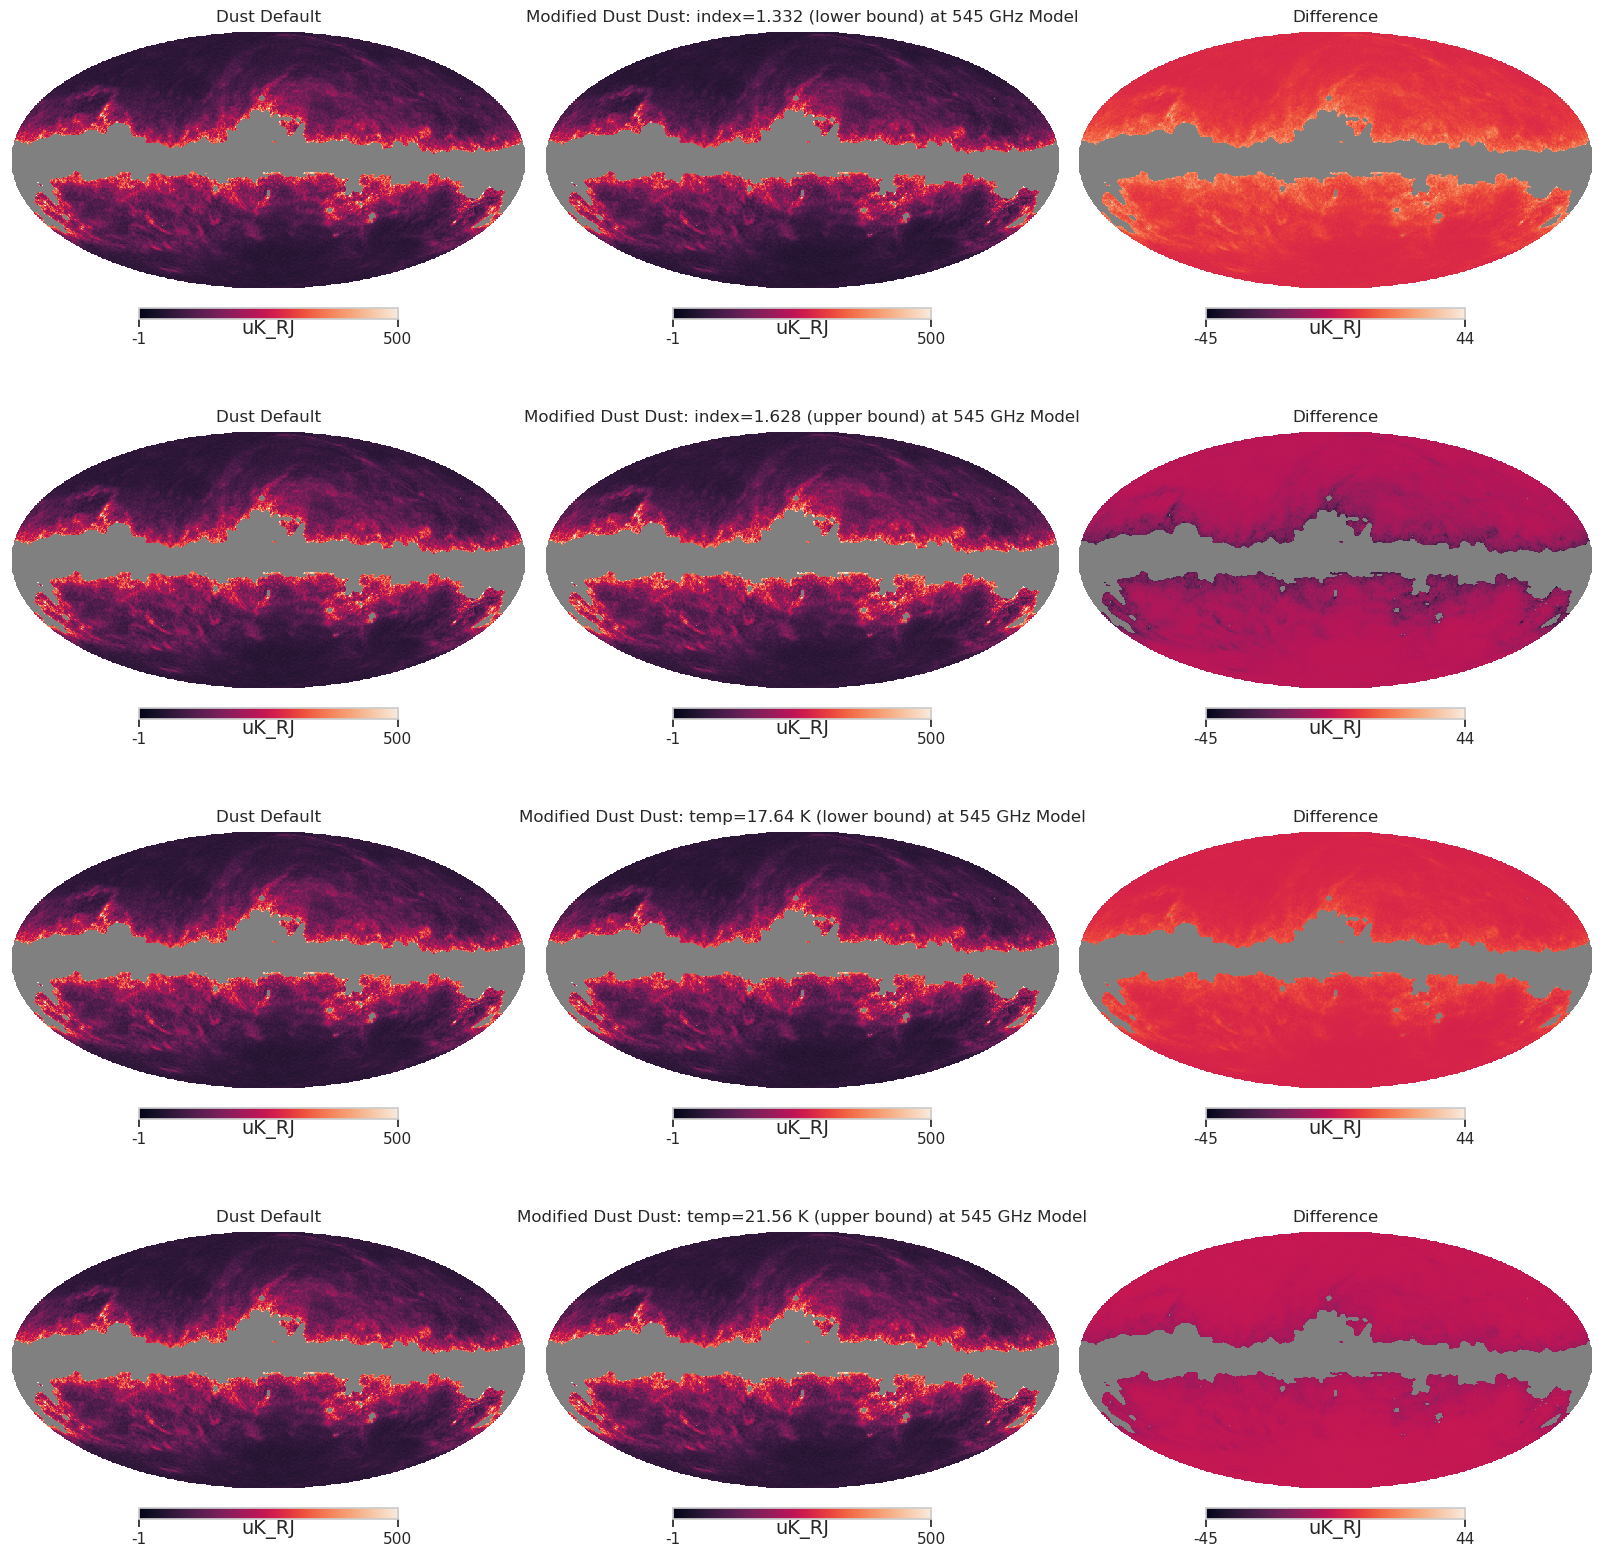

In [14]:
#gpt code to plot

min=-1
max=500

plt.figure(figsize=(16, 16))

# Lists of your maps and differences
dust_models = [sky_map_param1, sky_map_param2, sky_map_param3, sky_map_param4]
differences = [difference1, difference2, difference3, difference4]
v_values = [v1, v2, v3, v4]
titles = [f"Dust: index={dust_index_low.mbb_index} (lower bound) at {freq} GHz",
          f"Dust: index={dust_index_high.mbb_index} (upper bound) at {freq} GHz",
          f"Dust: temp={dust_temp_low.mbb_temperature} (lower bound) at {freq} GHz",
          f"Dust: temp={dust_temp_high.mbb_temperature} (upper bound) at {freq} GHz"]

# Loop through each dust model
for i, (model, diff, v) in enumerate(zip(dust_models, differences, v_values)):
    base_idx = i * 3  # Calculate subplot index

    # Default map
    hp.mollview(
        map_dust_default_mask,
        title="Dust Default",
        sub=(4, 3, base_idx + 1),
        unit=map_dust_default.unit,
        min=min,
        max=max
    )

    # Modified dust model
    hp.mollview(
        model,
        title=f"Modified Dust {titles[i]} Model",
        sub=(4, 3, base_idx + 2),
        unit=map_dust_default.unit,
        min=min,
        max=max
    )

    # Difference map
    hp.mollview(
        diff,
        title="Difference",
        sub=(4, 3, base_idx + 3),
        unit=map_dust_default.unit,
        min=-v//8,
        max=v//8
    )

plt.tight_layout()
plt.show()


In [15]:
m1 = map_dust_default_mask.flatten()
m2 = sky_map_param1.flatten()
diff = m1 - m2

# statistical tests
print("Mean difference:", np.mean(diff))
print("Std deviation of difference:", np.std(diff))

Mean difference: 7.829825503963533
Std deviation of difference: 4.598645301095511


In [16]:
type(diff)

numpy.ma.core.MaskedArray

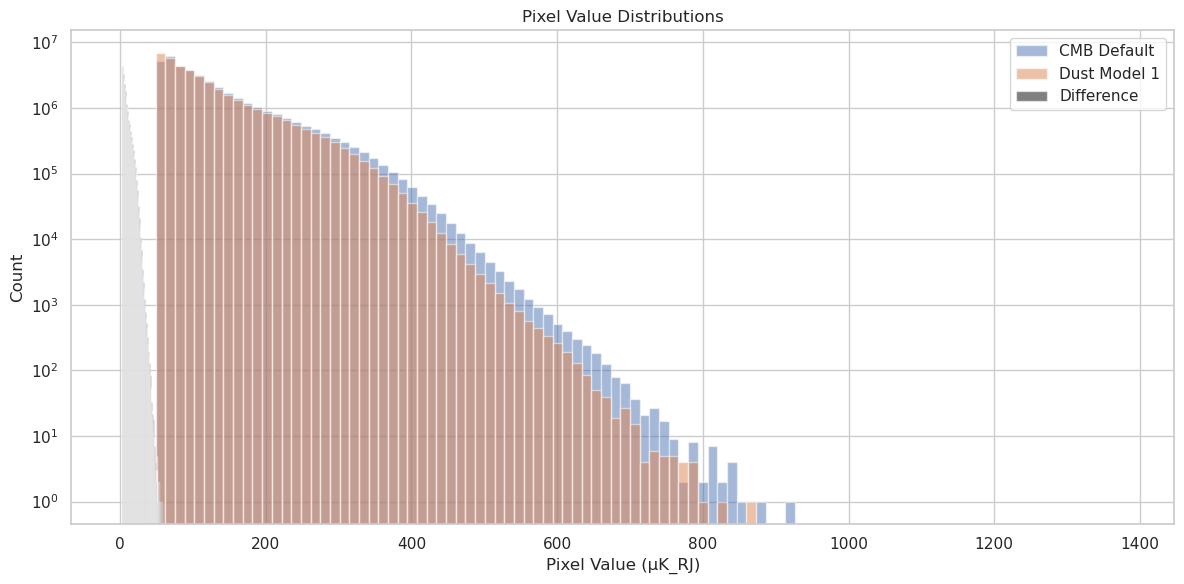

In [17]:
#only taking middle 99% of the pixel values for better visualization
vmin, vmax = np.percentile(m1, [0.5, 95])

plt.figure(figsize=(12, 6))

#.compressed() -> doesnt show the masked values
#turn these on or off to see the difference
plt.hist(m1.compressed(), bins=100, alpha=0.5, label="CMB Default", range=(vmin, vmax), log=True) 
plt.hist(m2.compressed(), bins=100, alpha=0.5, label="Dust Model 1", range=(vmin, vmax), log=True)
plt.hist(diff.compressed(), bins=100, alpha=0.5, label="Difference", color='black', log=True)

plt.xlabel("Pixel Value (μK_RJ)")
plt.ylabel("Count")
plt.title("Pixel Value Distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Mean temp difference calculations

In [18]:
mean_temp_default_dust = np.mean(map_dust_default_mask)
mean_temp_dust_1 = np.mean(sky_map_param1)
mean_temp_dust_2 = np.mean(sky_map_param2)
mean_temp_dust_3 = np.mean(sky_map_param3)
mean_temp_dust_4 = np.mean(sky_map_param4)

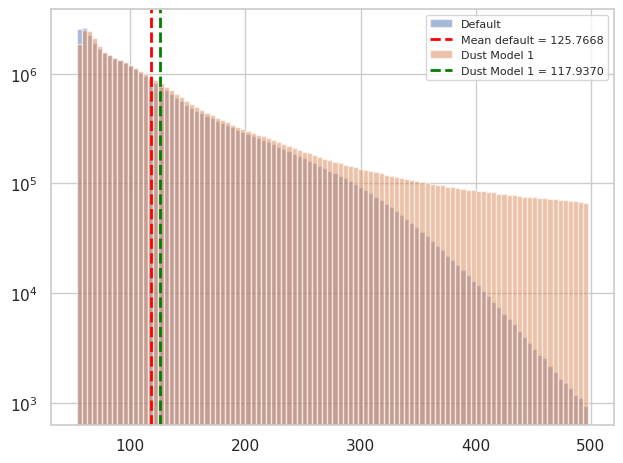

In [19]:

vmin, vmax = np.percentile(sky_map_param1, [5, 85])
plt.hist(sky_map_param1.compressed(), bins=100, alpha=0.5, label="Default", range=(vmin, vmax), log=True)
plt.axvline(mean_temp_dust_1, color='red', linestyle='dashed', linewidth=2, label=f"Mean default = {mean_temp_default_dust:.4f}")

plt.hist(map_dust_default_mask, bins=100, alpha=0.5, label="Dust Model 1", range=(vmin, vmax), log=True)
plt.axvline(mean_temp_default_dust, color='green', linestyle='dashed', linewidth=2, label=f"Dust Model 1 = {mean_temp_dust_1:.4f}")

plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
np.mean(map_dust_default_mask.compressed())

125.76681126488539

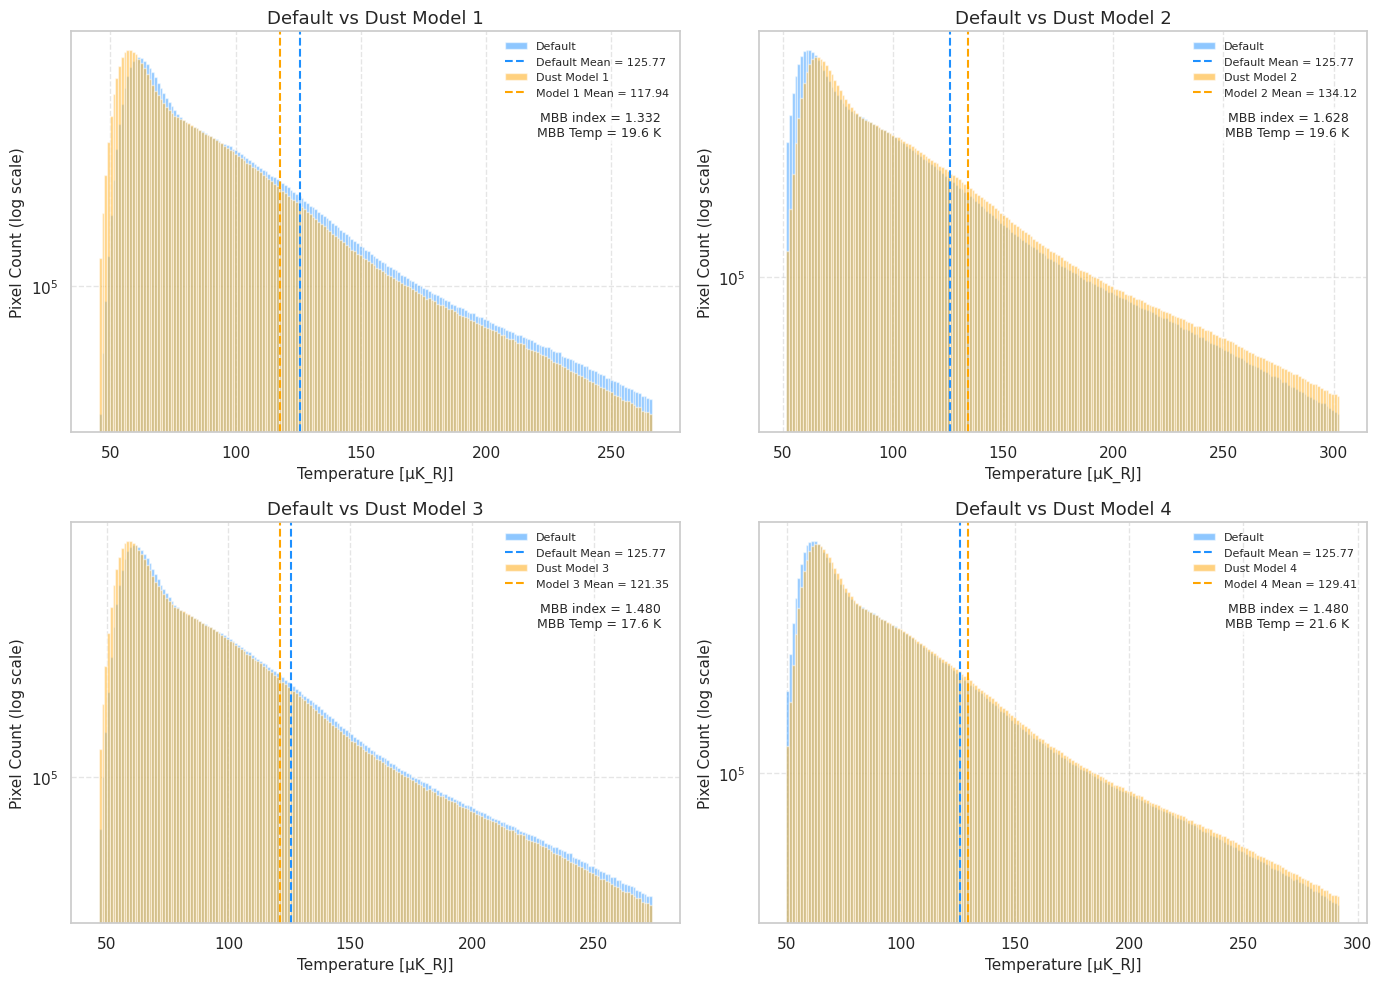

In [21]:
#chatgpt code for plotting histograms of dust models against the default map

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")

# Flatten masked array if needed
default_vals = map_dust_default_mask.compressed()

# dust models parameters
map_mbb_index = [1.332, 1.628, 1.48, 1.48]   
map_mbb_temperature = [19.6, 19.6, 17.64, 21.56]

# Precompute means
mean_temp_default = np.mean(default_vals)
means = [mean_temp_dust_1, mean_temp_dust_2, mean_temp_dust_3, mean_temp_dust_4]

models = [sky_map_param1, sky_map_param2, sky_map_param3, sky_map_param4]

# --- Create 2x2 grid of subplots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (ax, model, mean_model) in enumerate(zip(axes, models, means), start=1):
    # Percentile range for scaling
    vmin, vmax = np.percentile(model.compressed(), [0.5, 95])
    
    # Default histogram
    ax.hist(default_vals, bins=200, alpha=0.5, 
            label="Default", range=(vmin, vmax), log=True, color="dodgerblue")
    ax.axvline(mean_temp_default, color='dodgerblue', linestyle='dashed', linewidth=1.5,
               label=f"Default Mean = {mean_temp_default:.2f}")
    
    # Dust model histogram
    ax.hist(model.compressed(), bins=200, alpha=0.5, 
            label=f"Dust Model {i}", range=(vmin, vmax), log=True, color="orange")
    ax.axvline(mean_model, color='orange', linestyle='dashed', linewidth=1.5,
               label=f"Model {i} Mean = {mean_model:.2f}")

    # Add text box with parameters
    ax.text(0.97, 0.80, 
            f"MBB index = {map_mbb_index[i-1]:.3f}\nMBB Temp = {map_mbb_temperature[i-1]:.1f} K",
            transform=ax.transAxes, fontsize=9, va="top", ha="right",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6))
    
    # Labels & formatting
    ax.set_xlabel("Temperature [µK_RJ]", fontsize=11)
    ax.set_ylabel("Pixel Count (log scale)", fontsize=11)
    ax.set_title(f"Default vs Dust Model {i}", fontsize=13)
    ax.legend(fontsize=8, frameon=False)
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


## Free-Free model

In [54]:
from pysm3 import models

In [55]:
nside = 2048
freq = 70
sky = pysm3.Sky(nside=nside, preset_strings=["f1"])
map_ff_default = sky.get_emission(freq * u.GHz)  # Simulate at 100 GHz

In [56]:
map_ff_default_mask = get_masked_map(map_ff_default, mask)

In [57]:
map_ff_default_mask.shape

(50331648,)

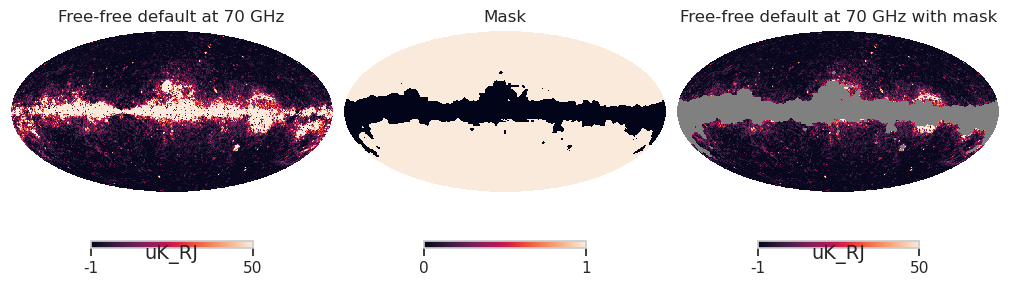

In [58]:
min=-1
max=50

plt.figure(figsize=(10, 10))
hp.mollview(map_ff_default[0], 
            title=f"Free-free default at {freq} GHz", 
            unit=map_dust_default.unit, 
            min = min, 
            max = max,
            sub=(1, 3, 1))

hp.mollview(mask, title="Mask", sub=(1, 3, 2))
hp.mollview(map_ff_default_mask, 
            title=f"Free-free default at {freq} GHz with mask", 
            unit=map_dust_default.unit, 
            min = min, 
            max = max,
            sub=(1, 3, 3))

plt.show()

## Modified Free-Free

In [59]:
base_ff = models.PowerLaw(
    nside=nside,
    map_I= "pysm_2/ff_t_new.fits",
    unit_I= "uK_RJ",
    map_pl_index= -2.14,
    freq_ref_I= "30 GHz",
    has_polarization= False
)

In [60]:
ff_index_low = copy.deepcopy(base_ff)
ff_index_high = copy.deepcopy(base_ff)
print(f"ff index low before modifying: {ff_index_low.pl_index}")
ff_index_low.pl_index = -1.926 * u.dimensionless_unscaled
ff_index_high.pl_index = -2.354 * u.dimensionless_unscaled
print(f"ff index after before modifying: {ff_index_low.pl_index}")

ff index low before modifying: -2.14
ff index after before modifying: -1.926


In [61]:
sky1 = pysm3.Sky(nside=nside, component_objects=[ff_index_low])
sky2 = pysm3.Sky(nside=nside, component_objects=[ff_index_high])

ff_param1_unmasked = sky1.get_emission(freq * u.GHz)  
map_ff_param1 = get_masked_map(ff_param1_unmasked, mask)
ff_param2_unmasked = sky2.get_emission(freq * u.GHz)
map_ff_param2 = get_masked_map(ff_param2_unmasked, mask)


In [62]:
print(ff_param2_unmasked.shape, map_ff_param2.shape)

(3, 50331648) (50331648,)


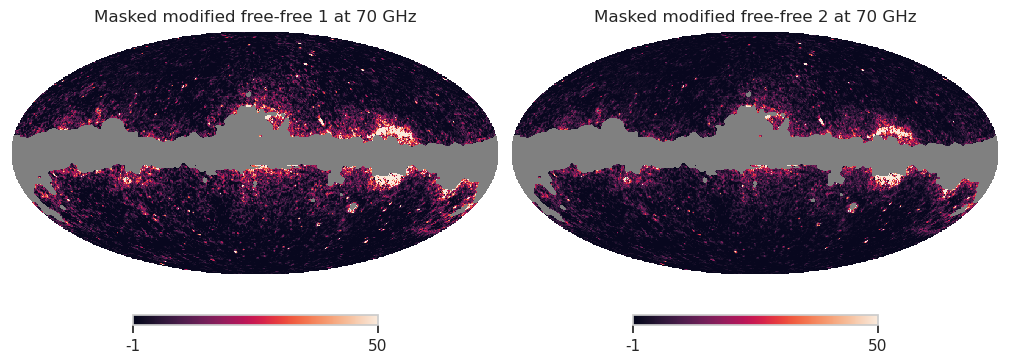

In [63]:
plt.figure(figsize=(10, 8))
hp.mollview(map_ff_param1, title=f"Masked modified free-free 1 at {freq} GHz", min = min, max = max, sub=(1, 2, 1))
hp.mollview(map_ff_param2, title=f"Masked modified free-free 2 at {freq} GHz", min = min, max = max, sub=(1, 2, 2))

plt.show()


## Difference of modified free-free maps

In [64]:
print(type(map_ff_default), type(map_ff_param1), type(map_dust_default_mask))

<class 'astropy.units.quantity.Quantity'> <class 'numpy.ma.core.MaskedArray'> <class 'numpy.ma.core.MaskedArray'>


In [65]:
difference1 = map_ff_default_mask - map_ff_param1
v1 = np.percentile(np.abs((difference1)), 90)
difference2 = map_ff_default_mask - map_ff_param2
v2 = np.percentile(np.abs((difference2)), 90)

/bigdata/aankit/miniconda/envs/cmb-ml-py-312/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


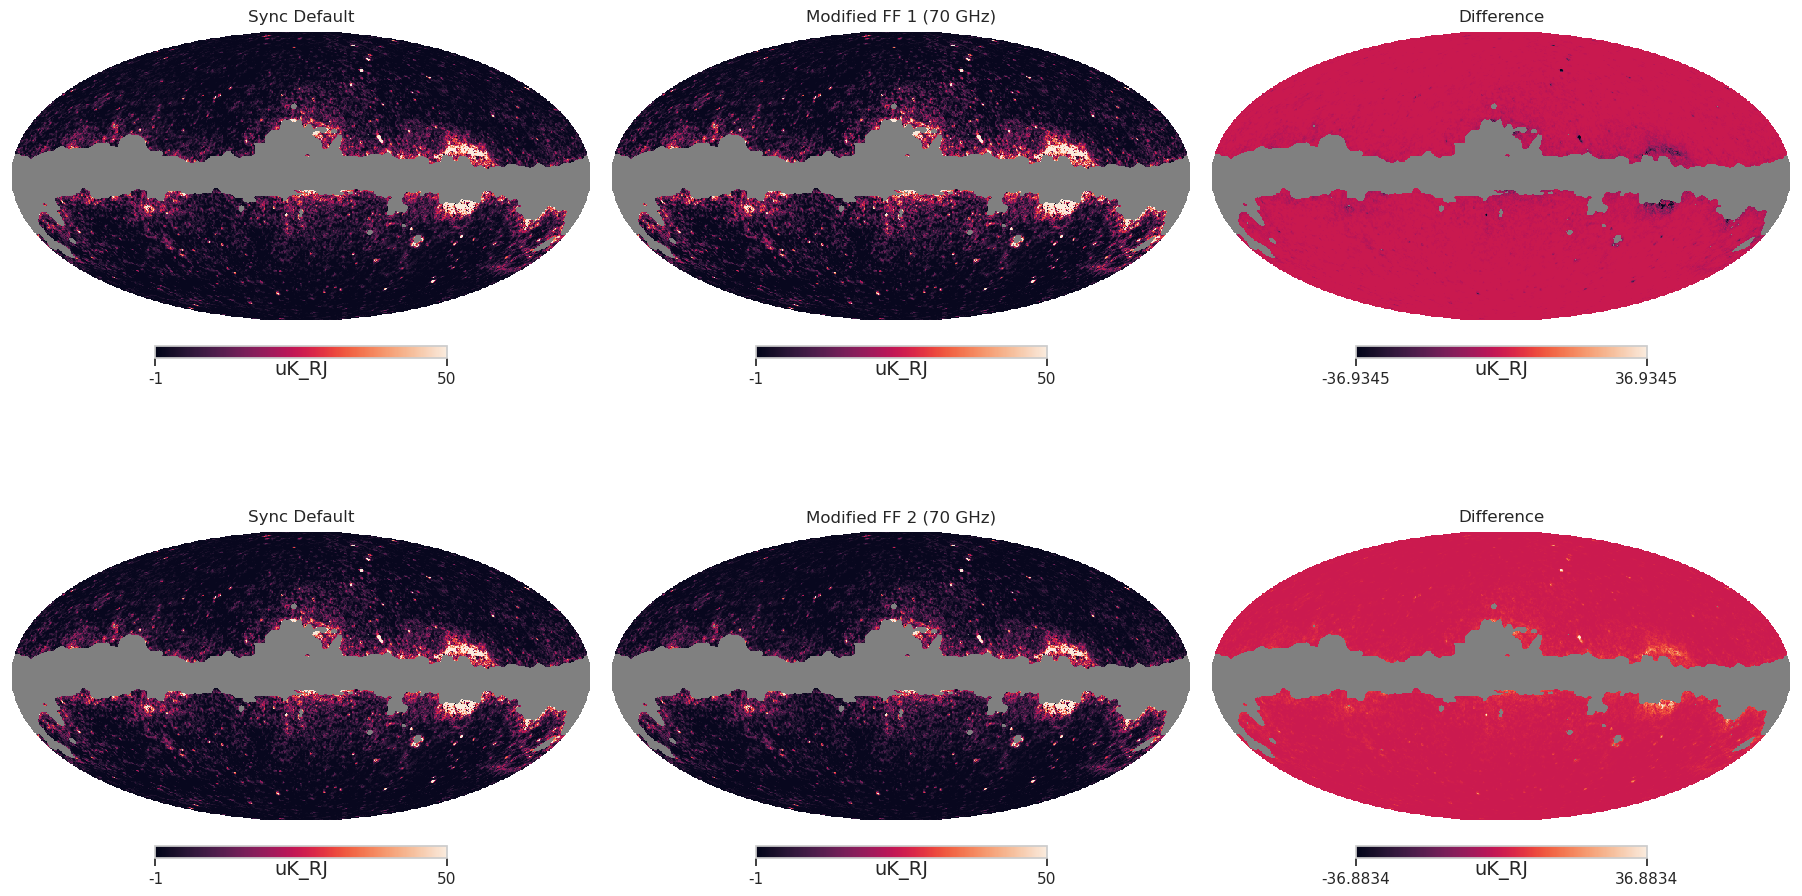

In [66]:
plt.figure(figsize=(18, 10))

ff_param = [map_ff_param1, map_ff_param2]
diff = [difference1, difference2]
v_vals = [v1, v2]  # for differences

for i in range(2):
    # Default
    hp.mollview(map_ff_default_mask,
                title="Sync Default",
                sub=(2, 3, i*3 + 1),
                unit=map_ff_default.unit,
                min=min,
                max=max)
    
    # Modified
    hp.mollview(ff_param[i],
                title=f"Modified FF {i+1} ({freq} GHz)",
                sub=(2, 3, i*3 + 2),
                unit=map_ff_default.unit,
                min=min,
                max=max)
    
    # Difference
    hp.mollview(diff[i],
                title="Difference",
                sub=(2, 3, i*3 + 3),
                unit=map_ff_default.unit,
                min=-v_vals[i],
                max=v_vals[i])

plt.show()


In [35]:
m1 = map_ff_default_mask.flatten()
m2 = map_ff_param2.flatten()
diff = m1 - m2

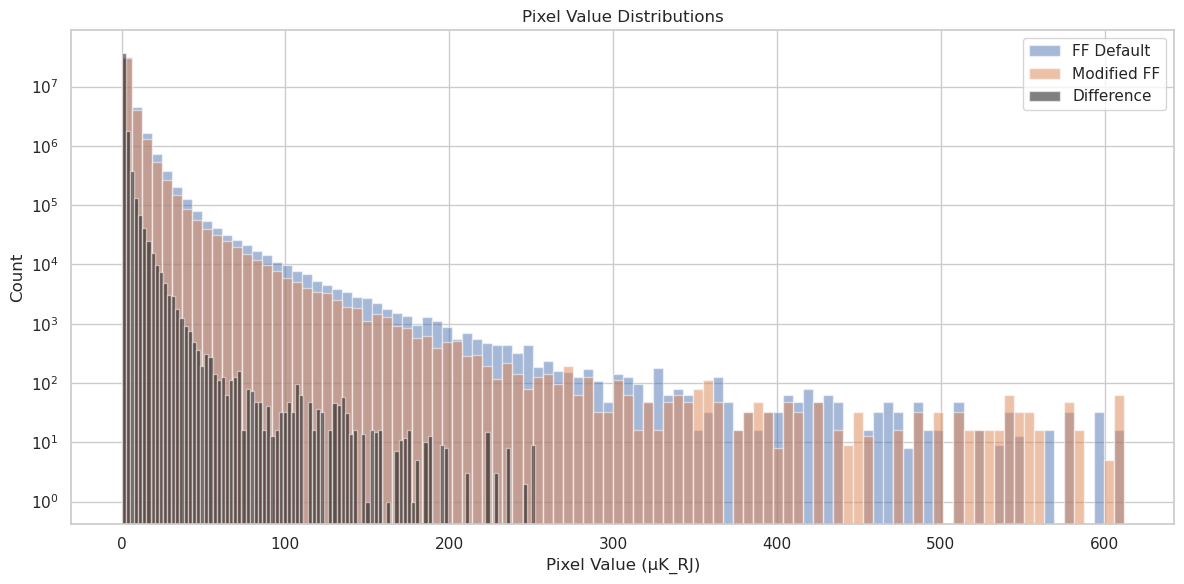

In [36]:
#only taking middle 99% of the pixel values for better visualization
vmin, vmax = np.percentile(m1, [0.5, 99])

plt.figure(figsize=(12, 6))

#turn these on or off to see the difference
plt.hist(m1.compressed(), bins=100, alpha=0.5, label="FF Default", range=(vmin, vmax), log=True) 
plt.hist(m2.compressed(), bins=100, alpha=0.5, label="Modified FF", range=(vmin, vmax), log=True)
plt.hist(diff.compressed(), bins=100, alpha=0.5, label="Difference", color='black', log=True)

plt.xlabel("Pixel Value (μK_RJ)")
plt.ylabel("Count")
plt.title("Pixel Value Distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Mean temp difference calculations

In [37]:
mean_temp_default_ff = np.mean(map_ff_default_mask)
mean_temp_ff_1 = np.mean(map_ff_param1)
mean_temp_ff_2 = np.mean(map_ff_param2)

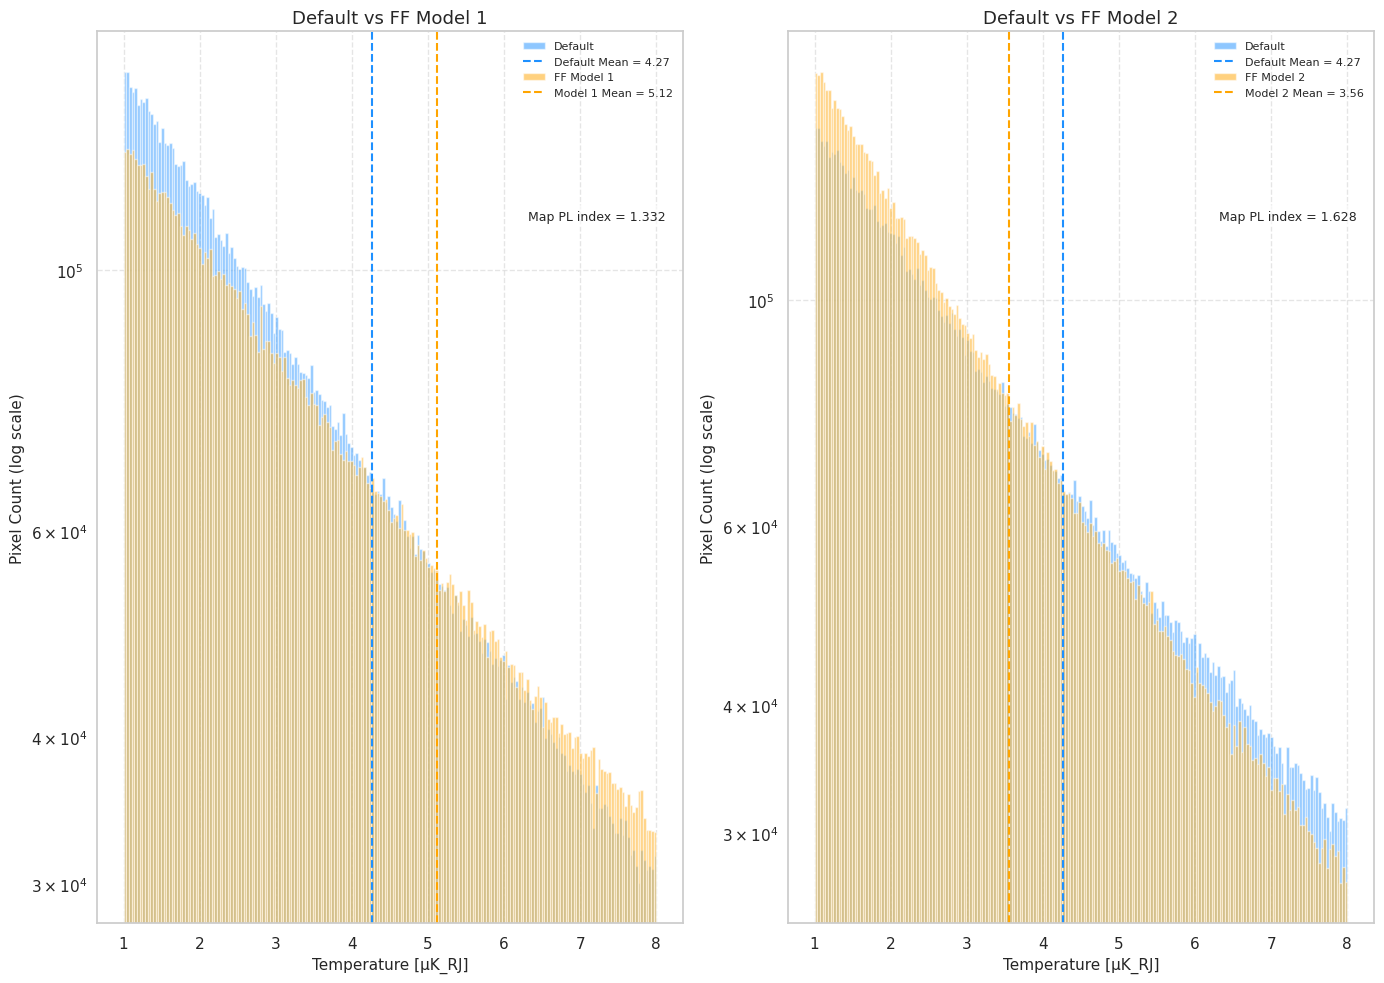

In [38]:
#chatgpt code for plotting histograms of dust models against the default map

# Flatten masked array if needed
default_vals = map_ff_default_mask.compressed()

# dust models parameters
map_pl_index= [-1.926, -2.354]  

# Precompute means
mean_temp_default = np.mean(default_vals)
means = [mean_temp_ff_1,
         mean_temp_ff_2  
]

models = [map_ff_param1, map_ff_param2]

# --- Create 1x2 grid of subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (ax, model, mean_model) in enumerate(zip(axes, models, means), start=1):
    # Percentile range for scaling
    vmin, vmax = 1, 8#np.percentile(model.compressed(), [30, 90])
    
    # Default histogram
    ax.hist(default_vals, bins=200, alpha=0.5, 
            label="Default", range=(vmin, vmax), log=True, color="dodgerblue")
    ax.axvline(mean_temp_default, color='dodgerblue', linestyle='dashed', linewidth=1.5,
               label=f"Default Mean = {mean_temp_default:.2f}")
    
    # Dust model histogram
    ax.hist(model.compressed(), bins=200, alpha=0.5, 
            label=f"FF Model {i}", range=(vmin, vmax), log=True, color="orange")
    ax.axvline(mean_model, color='orange', linestyle='dashed', linewidth=1.5,
               label=f"Model {i} Mean = {mean_model:.2f}")

    # Add text box with parameters
    ax.text(0.97, 0.80, 
            f"Map PL index = {map_mbb_index[i-1]:.3f}",
            transform=ax.transAxes, fontsize=9, va="top", ha="right",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6))
    
    # Labels & formatting
    ax.set_xlabel("Temperature [µK_RJ]", fontsize=11)
    ax.set_ylabel("Pixel Count (log scale)", fontsize=11)
    ax.set_title(f"Default vs FF Model {i}", fontsize=13)
    ax.legend(fontsize=8, frameon=False)
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


## Synchrotron Model

In [39]:
from pysm3 import models

In [40]:
nside = 2048
freq = 100
sky = pysm3.Sky(nside=nside, preset_strings=["s4"]) 
map_sync_default = sky.get_emission(freq * u.GHz)  

In [41]:
map_sync_default_mask = get_masked_map(map_sync_default, mask)

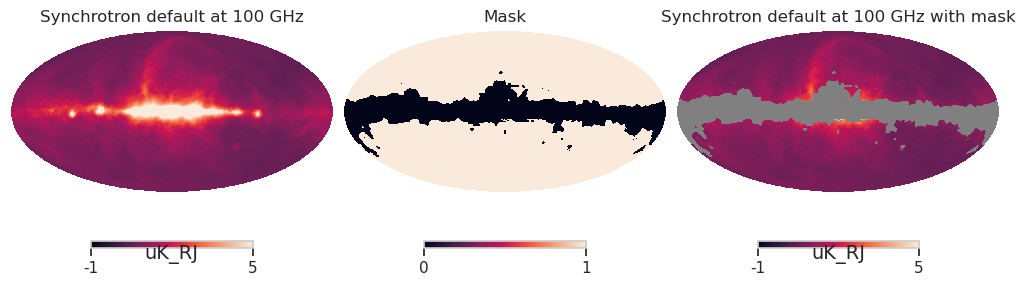

In [42]:
min = -1
max = 5

plt.figure(figsize=(10, 10))
hp.mollview(map_sync_default[0], 
            title=f"Synchrotron default at {freq} GHz", 
            unit=map_dust_default.unit, 
            min = min, 
            max = max,
            sub=(1, 3, 1))

hp.mollview(mask, title="Mask", sub=(1, 3, 2))
hp.mollview(map_sync_default_mask, 
            title=f"Synchrotron default at {freq} GHz with mask", 
            unit=map_dust_default.unit, 
            min = min, 
            max = max,
            sub=(1, 3, 3))

plt.show()

## Modified Synchrotron

In [43]:
base_sync = models.PowerLaw(
    nside=nside,
    map_I="synch/synch_template_nside2048_2023.02.25.fits",
    map_pl_index=-3.1,
    freq_ref_I="23 GHz",
    freq_ref_P="23 GHz",
    has_polarization=False
)

In [44]:
sync_index_low = copy.deepcopy(base_sync)
sync_index_high = copy.deepcopy(base_sync)
print(f"ff index low before modifying: {sync_index_low.pl_index}")
sync_index_low.pl_index = -2.79 * u.dimensionless_unscaled
sync_index_high.pl_index = -3.41 * u.dimensionless_unscaled
print(f"ff index after before modifying: {sync_index_low.pl_index}")

ff index low before modifying: -3.1
ff index after before modifying: -2.79


In [45]:
sky1 = pysm3.Sky(nside=nside, component_objects=[sync_index_low])
sky2 = pysm3.Sky(nside=nside, component_objects=[sync_index_high])

sync_param1_unmasked = sky1.get_emission(freq * u.GHz)  
map_sync_param1 = get_masked_map(sync_param1_unmasked, mask)
sync_param2_unmasked = sky2.get_emission(freq * u.GHz)
map_sync_param2 = get_masked_map(sync_param2_unmasked, mask)


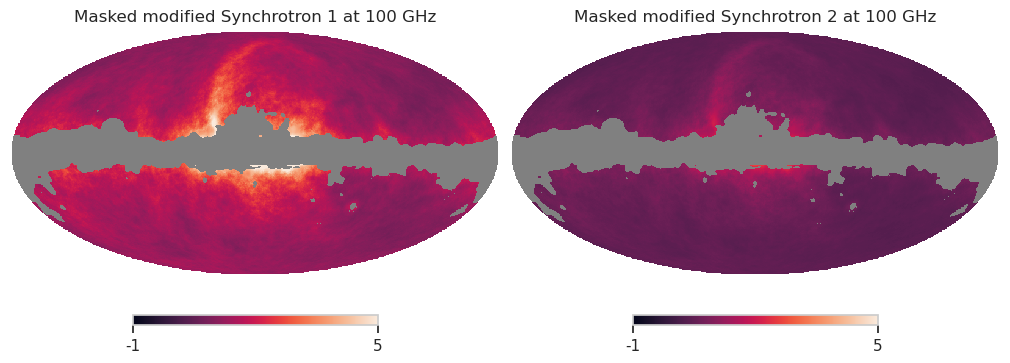

In [46]:
plt.figure(figsize=(10, 8))
hp.mollview(map_sync_param1, title=f"Masked modified Synchrotron 1 at {freq} GHz", min = min, max = max, sub=(1, 2, 1))
hp.mollview(map_sync_param2, title=f"Masked modified Synchrotron 2 at {freq} GHz", min = min, max = max, sub=(1, 2, 2))

plt.show()


## Difference of modified Synchrotron maps

In [47]:
difference1 = map_sync_default_mask - map_sync_param1
v1 = np.percentile(np.abs((difference1)), 90)
difference2 = map_sync_default_mask - map_sync_param2
v2 = np.percentile(np.abs((difference2)), 90)

/bigdata/aankit/miniconda/envs/cmb-ml-py-312/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


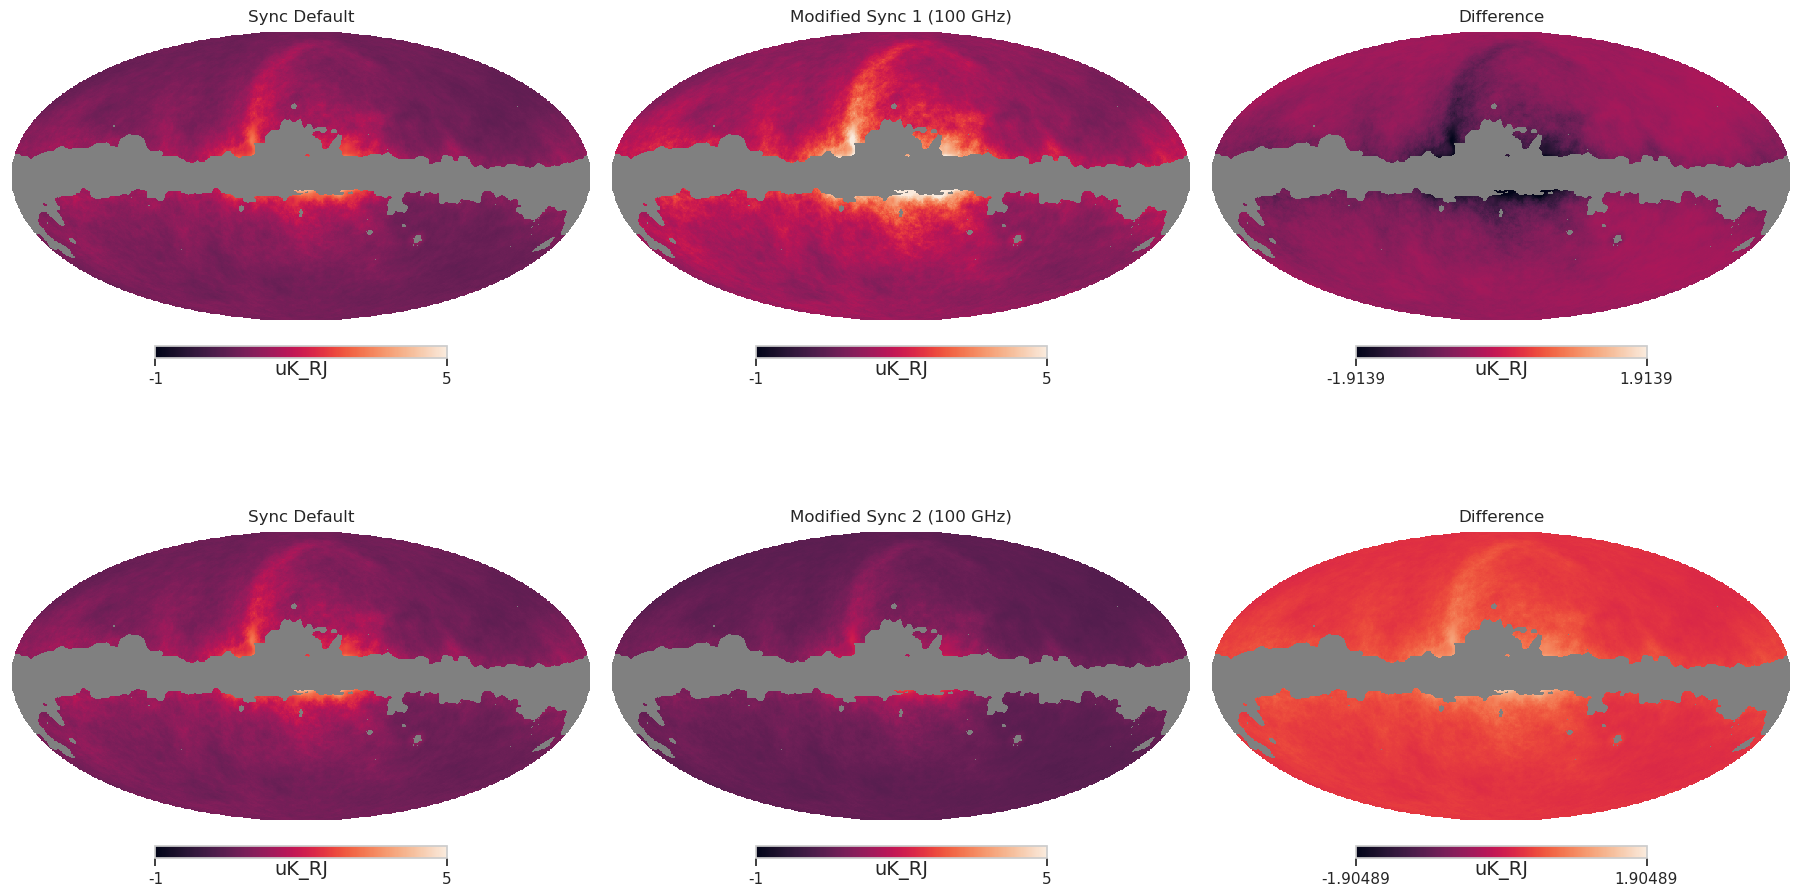

In [48]:
plt.figure(figsize=(18, 10))

sync_param = [map_sync_param1, map_sync_param2]
diff = [difference1, difference2]
v_vals = [v1, v2]  # for differences

for i in range(2):
    # Default
    hp.mollview(map_sync_default_mask,
                title="Sync Default",
                sub=(2, 3, i*3 + 1),
                unit=map_sync_default.unit,
                min=min,
                max=max)
    
    # Modified
    hp.mollview(sync_param[i],
                title=f"Modified Sync {i+1} ({freq} GHz)",
                sub=(2, 3, i*3 + 2),
                unit=map_sync_default.unit,
                min=min,
                max=max)
    
    # Difference
    hp.mollview(diff[i],
                title="Difference",
                sub=(2, 3, i*3 + 3),
                unit=map_sync_default.unit,
                min=-v_vals[i],
                max=v_vals[i])

plt.show()


In [49]:
m1 = map_sync_default_mask.flatten()
m2 = map_sync_param2.flatten()
diff = m1 - m2

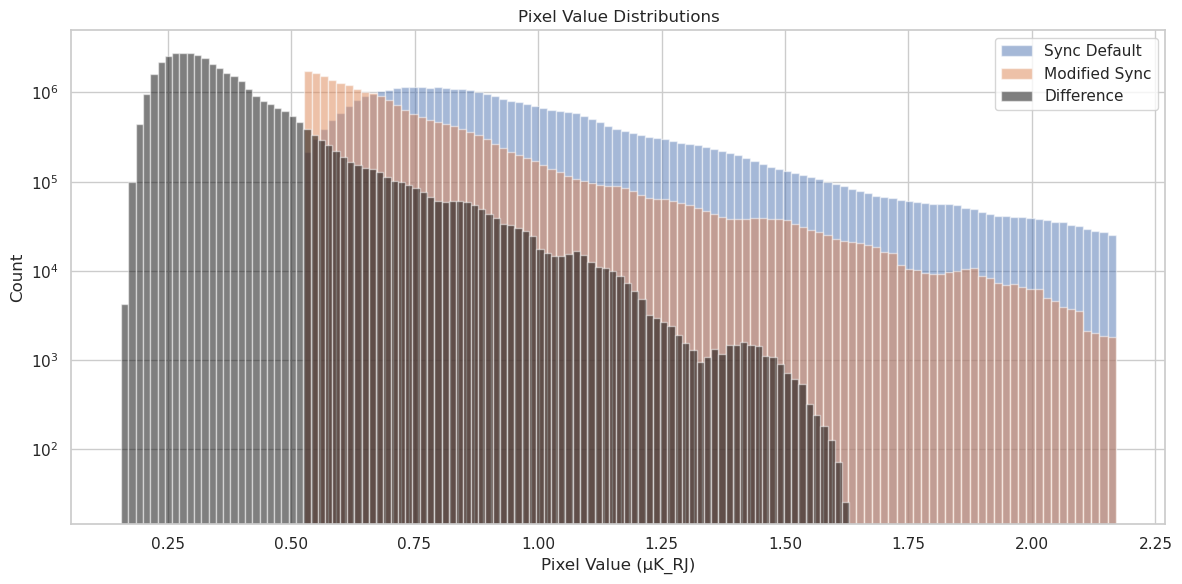

In [50]:
#only taking middle 99% of the pixel values for better visualization
vmin, vmax = np.percentile(m1, [0.5, 90])

plt.figure(figsize=(12, 6))

#turn these on or off to see the difference
plt.hist(m1.compressed(), bins=100, alpha=0.5, label="Sync Default", range=(vmin, vmax), log=True) 
plt.hist(m2.compressed(), bins=100, alpha=0.5, label="Modified Sync", range=(vmin, vmax), log=True)
plt.hist(diff.compressed(), bins=100, alpha=0.5, label="Difference", color='black', log=True)

plt.xlabel("Pixel Value (μK_RJ)")
plt.ylabel("Count")
plt.title("Pixel Value Distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Mean temp difference calculations

In [51]:
mean_temp_default_sync = np.mean(map_sync_default_mask)
mean_temp_sync_1 = np.mean(map_sync_param1)
mean_temp_sync_2 = np.mean(map_sync_param2)

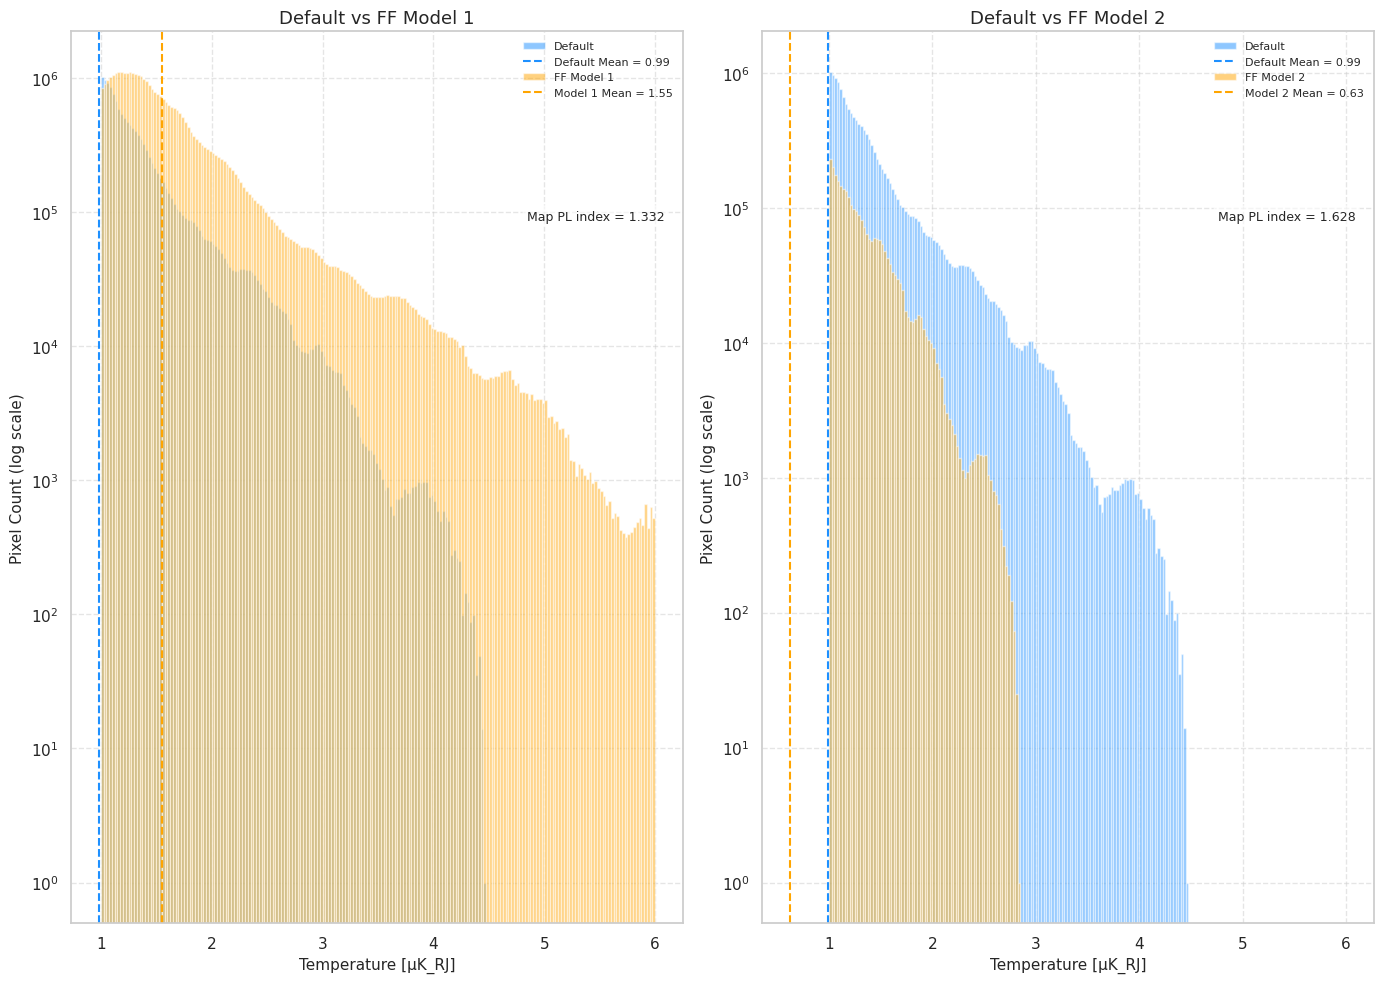

In [52]:
#chatgpt code for plotting histograms of dust models against the default map

# Flatten masked array if needed
default_vals = map_sync_default_mask.compressed()

# dust models parameters
map_pl_index= [-1.926, -2.354]  

# Precompute means
mean_temp_default = np.mean(default_vals)
means = [mean_temp_sync_1,
         mean_temp_sync_2  
]

models = [map_sync_param1, map_sync_param2]

# --- Create 1x2 grid of subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (ax, model, mean_model) in enumerate(zip(axes, models, means), start=1):
    # Percentile range for scaling
    vmin, vmax = 1,6 #np.percentile(model.compressed(), [.5, 80])
    
    # Default histogram
    ax.hist(default_vals, bins=200, alpha=0.5, 
            label="Default", range=(vmin, vmax), log=True, color="dodgerblue")
    ax.axvline(mean_temp_default, color='dodgerblue', linestyle='dashed', linewidth=1.5,
               label=f"Default Mean = {mean_temp_default:.2f}")
    
    # Dust model histogram
    ax.hist(model.compressed(), bins=200, alpha=0.5, 
            label=f"FF Model {i}", range=(vmin, vmax), log=True, color="orange")
    ax.axvline(mean_model, color='orange', linestyle='dashed', linewidth=1.5,
               label=f"Model {i} Mean = {mean_model:.2f}")

    # Add text box with parameters
    ax.text(0.97, 0.80, 
            f"Map PL index = {map_mbb_index[i-1]:.3f}",
            transform=ax.transAxes, fontsize=9, va="top", ha="right",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6))
    
    # Labels & formatting
    ax.set_xlabel("Temperature [µK_RJ]", fontsize=11)
    ax.set_ylabel("Pixel Count (log scale)", fontsize=11)
    ax.set_title(f"Default vs FF Model {i}", fontsize=13)
    ax.legend(fontsize=8, frameon=False)
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
